In [ ]:
# Import relevant packages for GEE analysis
import ee
import geemap

# import libraries that we need for graph analysis
from libpysal import weights
import matplotlib.pyplot as plt
import networkx as nx
import geopandas
import numpy as np

In [ ]:
# Initialisie earth engine
ee.Authenticate()
ee.Initialize()

In [2320]:
# magic command to render plots in notebook
%matplotlib inline

### Broadleaf cover

In [2321]:
# Load a polygon of the UK so that we can clip the CORINE dataset
ukPoly = ee.FeatureCollection('USDOS/LSIB_SIMPLE/2017') \
         .filter(ee.Filter.eq('country_co', 'UK'))

# Load the Corine landcover categorisation for 2018 (the latest)
# Each pixel represents 100m x 100m or 1 hectare
# Select the landcover band and clip to the UK border
corine = ee.Image('COPERNICUS/CORINE/V20/100m/2018') \
    .select('landcover') \
    .clipToCollection(ukPoly)

# Select pixels that represent Broadleaf categorisation (311)
mask = corine.eq(311)
# Generate a broadleaf image by using the mask for 311
broadleaf = mask.updateMask(mask).multiply(corine)

In [2322]:
# Create a map
Map = geemap.Map()
# Centre on the UK
Map.setCenter(-1.2589, 51.7521, 8)
# Plot the map
Map.addLayer(broadleaf, {'palette' : 'red'}, 'Broadleaf', True)

If we load the administrative boundariies for the Uk, we can plot them and then calculate the percentage of landcover within a county that is broadleaf woodland.

In [2323]:
# Select UK Counties from the GAUL feature collection
# "U.K. of Great Britain and Northern Ireland"

uk = ee.FeatureCollection("FAO/GAUL_SIMPLIFIED_500m/2015/level2") \
              .filter(ee.Filter.eq('ADM0_NAME', "U.K. of Great Britain and Northern Ireland") \
)

Let's visualise the broadleaf woodland and county boundaries

In [2324]:
# Plot map
Map.addLayer(uk, {}, 'uk counties')
Map

Map(center=[51.7521, -1.2589], controls=(WidgetControl(options=['position', 'transparent_bg'], widget=HBox(chi…

What is the total area of broadleaf woodland within the UK? Let's start with the total area of the UK

In [2325]:
# disolve feature collection into single polygon
# then extract area
# convert from m2 to km2
area = uk.geometry().area().getInfo()/1e6
print("Total uk land area: ", area, " km2")

Total uk land area:  243266.3252841075  km2


Then we can work out the total area covered by broadleaf woodland

In [2326]:
areaImage = mask.multiply(ee.Image.pixelArea())
area = areaImage.reduceRegion(
    reducer   = ee.Reducer.sum(),
    geometry  = uk.geometry(),
    scale     = 100,
    maxPixels = 1e10
    )

In [2327]:
broadleafCover = area.getInfo()

What is the total area of broadleaf trees iin the UK?

In [2328]:
print("Total uk broadleaf forest area: ", broadleafCover["landcover"] / (1e6), " km2")

Total uk broadleaf forest area:  5454.368235294117  km2


### Broadleaf woodland area by UK county

Not let's calculate the percentage broadleaf cover for each UK county, and then order them

In [2329]:
# Define broadleaf mask for UK
ukBroadleafImage = mask.multiply(ee.Image.pixelArea())

# Functionn to map over counties (features) within UK featureCollection
def mapCounties(county):
    
    # Calculate county area and set property
    countyArea = county.geometry().area().divide(1e6).round()
    # Set a property within the county feature to capture the county area
    county = county.set('County_Area', countyArea)
    
    # Calculate broadleaf area within county
    broadleafArea = ukBroadleafImage.reduceRegion(
        reducer   = ee.Reducer.sum(),
        geometry  = county.geometry(),
        scale     = 100,
        maxPixels = 1e10
    ).get("landcover")
    
    # Convert broadleaf area into km2
    broadleafArea = ee.Number.float(broadleafArea).divide(1e6)
    # Set a property within the county feature to capture broadleaf area for the county
    county = county.set('Broadleaf_Area', broadleafArea)
    
    # Percentage broadleaf
    percentageBroadleaf = broadleafArea.divide(countyArea).multiply(100)
    # Set a property within the county feature to capture the % broadleaf
    county = county.set('Broadleaf_Per', percentageBroadleaf)

    # return updated feature
    return county
    
# Map over uk counties and calulcate the county area and the broadleaf woodland area within it
broadleafAreaByCounty = uk.map(mapCounties)

In [2330]:
broadleafAreaByCounty.aggregate_sum("Broadleaf_Area").getInfo()

5454.317529411764

In [2331]:
broadleafByCounty_df = geemap.ee_to_df(broadleafAreaByCounty)

In [2332]:
broadleafByCounty_df[["ADM2_NAME","County_Area","Broadleaf_Area","Broadleaf_Per"]] \
.sort_values("Broadleaf_Per", ascending=False) \
.head(10)

,ADM2_NAME,County_Area,Broadleaf_Area,Broadleaf_Per
39,Surrey,1677,185.679176,11.072104
43,West Sussex,1940,173.617373,8.949349
18,Hampshire,3738,280.165137,7.495055
13,East Sussex,1742,115.605608,6.636372
2,Berkshire,1219,79.154510,6.493397
23,Kent,3694,236.598902,6.404951
92,West Glamorgan,818,47.270863,5.778834
3,Buckinghamshire,1901,100.002235,5.260507
15,Gloucestershire,2619,130.236824,4.972769
22,Isle of Wight,374,17.354902,4.640348


Plot of percentage of broadleaf coverage across the UK

In [2333]:
empty = ee.Image().byte()

# Paint all the county polygon edges with the same number and width, display.
outline = empty.paint(
  featureCollection = broadleafAreaByCounty,
  color = 'Broadleaf_Per'
)
visParams = {
  'palette': ['white', 'green'],
  'min': 0,
  'max': 11,
  'opacity': 1
}

Map.addLayer(outline, visParams, 'broadleaf coverage')
Map

Map(bottom=43872.0, center=[51.52925135518991, -0.5191235760248759], controls=(WidgetControl(options=['positio…

### Broadleaf connectivity analysis

Broadleaf woods are clearly more dominant in the south east of England. Let's analyse how well connected they are, with the goal of working out how to enhance connectivity between broadleaf habitats.

#### Vectorise the broadleaf layer

Let's start with one county, Oxfordshire. by focusing on one county to start with, hopefully the initial analysis easier to understand.

In [1595]:
# Generate polygon for Oxfordshire
oxon = uk.filter(ee.Filter.eq('ADM2_NAME', "Oxfordshire"))

# Vectorise all broadleaf pixels in Oxfordshire
vectors = broadleaf.reduceToVectors(
    reducer = ee.Reducer.countEvery(),
    geometry = oxon,
    scale = 100,
    maxPixels = 1e8
)

# Put the result into a feature collection
oxonBroadleaf = ee.FeatureCollection(vectors)

# Now convert into a geopandas data frane
oxonBroadleaf_df = geemap.ee_to_gdf(oxonBroadleaf)

# Set and reproject to OSG36
oxonBroadleaf_df = oxonBroadleaf_df.set_crs(epsg=4326)
oxonBroadleaf_df = oxonBroadleaf_df.to_crs('epsg:27700')

In [1596]:
# Let's eyeball the data
oxonBroadleaf_df.head()

,geometry,count,label
0,"POLYGON ((424529.257 196170.443, 424628.068 19...",60,311
1,"POLYGON ((424193.103 207339.909, 424390.719 20...",42,311
2,"POLYGON ((428695.244 180882.898, 428794.054 18...",107,311
3,"MULTIPOLYGON (((423212.696 218099.367, 423245....",35,311
4,"MULTIPOLYGON (((422816.709 216820.087, 422915....",62,311


Looks like we need to first calculate the centroids for each of the woodland regions (polygon regions), before creating a graph to analyse

In [2318]:
# calculate centroids for Oxon broadleaf woodlands
centroids = np.column_stack((oxonBroadleaf_df.centroid.x, oxonBroadleaf_df.centroid.y))

In order to create a grpah where all nodes are connected we need to use a distance band around each node. By setting this manually, it seems the minimum distance band to create a graph where all nodes are connected is around 15km.

In [1650]:
## The 15km distance band graph will connect all pairs of points
## that are within 15km from one another. This means that nodes
## may have different degree (connections with other neighbours).
dist = weights.DistanceBand.from_array(centroids, threshold=5000)

# Convert to a networkx obejct
dist_graph = dist.to_networkx()

# To plot with networkx, we need to merge the nodes back to
# their positions in order to plot in networkx
positions = dict(zip(dist_graph.nodes, centroids))

/Users/anthony/miniconda3/lib/python3.9/site-packages/libpysal/weights/weights.py:172: UserWarning: The weights matrix is not fully connected: 
 There are 17 disconnected components.
 There are 10 islands with ids: 1, 2, 11, 35, 38, 41, 57, 75, 78, 92.
  warnings.warn(message)


Now we can draw the graph, given that we connected all node centroids that are within 15km of each other. It can be seen that there are two distinct clusters of nodes and a third very small cluster to the south west.

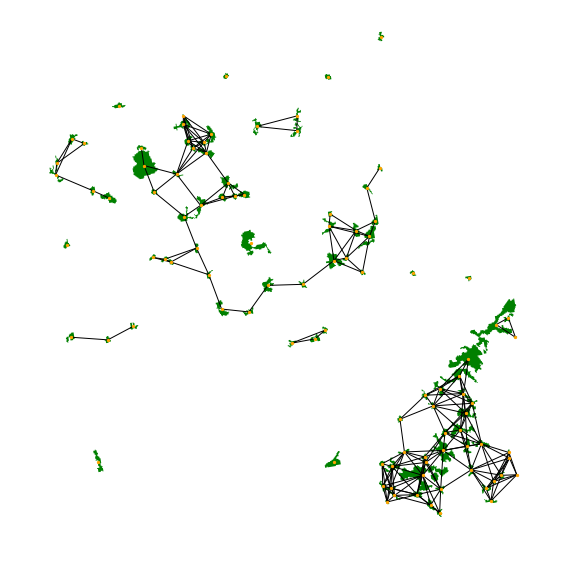

In [2302]:
# Plot the woodlands (green) and their centroids (orange)
x = centroids[:,0]
y = centroids[:,1]

#fig, ax = plt.subplots()
ax = oxonBroadleaf_df.plot(figsize=(10,25),color='g')
ax = nx.draw(dist_graph, positions, node_size=5, node_color="orange")
plt.show()

Test that there is only onlt component (= a fully connected graph)

In [1619]:
nx.number_connected_components(dist_graph)

1

What is the distribution of node degrees across this fully connected graph? We can see below that are alot of nodes have a high degree. This implies that a large number of nodes are fairly close to each other

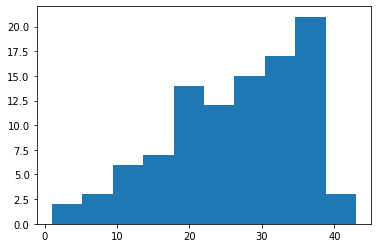

In [1614]:
def plot_degree_dist(G):
    degrees = [dist_graph.degree(n) for n in dist_graph.nodes()]
    plt.hist(degrees)
    plt.show()

plot_degree_dist(T)

Can we determine how the component connectivity changes as a function of the distance band?

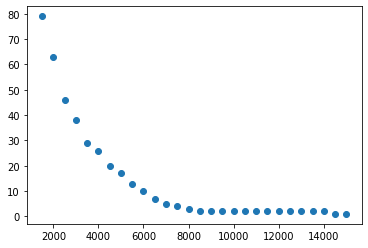

In [1648]:
def components_by_threshold(thr):
    w = weights.DistanceBand.from_array(centroids, threshold=thr,silence_warnings=True)
    g = w.to_networkx()
    c = nx.number_connected_components(g)
    return (thr,c)

comps = [components_by_threshold(i) for i in range(15000, 1000, -500)]
plt.scatter(*zip(*comps))

We can see that a distance band of 5km means there are 17 disconnected subgraphs (components). What would the minimum distance band be (in km) in order to achieve a fully connected graph, if an additional ten broadleaf woodlands (area of at least 1Ha) were planted? The idea would be that a fully connected graph at a lower distance band would mean it easier for species to move across the woodland landscape.

### Optimise the connectivity of Oxfordhsire woodland

In [1649]:
# Import GA library
import pygad

**Problem definition**

Oxfordshire has around 90km2 of broadleaf woodland. If we wanted to ensure that all current woodland patches are within 5km of each other, where would be the best place to locate additional 1ha patches inorder to achieve this?

Our objective is optimise the location of n additional centroids (x1,y1)...(xn,yn) within the existing woodland network of Oxon, in order too minimise the number of disconnected components. More specifically we want to achieve a fully connected graph. A network metric measuring the number of components within the graph is the networkx function:

`networkx.number_connected_components(G)`

, where a fully connected graph, G, has 1 connected components.

**Fitness function**

Function inputs are:

- the centroids of polygons representing the current broadlead woodland that covers Oxfordshire, $c_i = (x_i,y_i)$.
- set the permitted high/low values for solution coordinates

Process to evalute fitness function:

1. Given the solution coordinates $s_j = (x_j,y_j)$, $j=1..n$ determine $G(s,c)$ using a distance weighted kernel that is set to 5km. see https://geographicdata.science/book/notebooks/04_spatial_weights.html
2. Calculate the number of connected components for the graph $G$, $l = CPL(G)$ 
3. Calculate the fitness, $f = 1/l$

In [2281]:
# Constants for fitness function
no_comps_target = 1             # a connected graph has 1 component
max_dist_between_nodes = 5000   # in km
num_pts = 25                    # number of new woodlands @ 1ha 
num_genes = num_pts*2           # number of genes required with the GA
num_nodes = nx.number_of_nodes(dist_graph)

# Generate coordinate np array of existing woodlands
centroids = np.column_stack((oxonBroadleaf_df.centroid.x, oxonBroadleaf_df.centroid.y))

# Create indcies for new woodlands within the GA solution list
y_ix = [x for x in range(num_genes) if x % 2 != 0] 
x_ix = [x for x in range(num_genes) if x % 2 == 0] 

# Define fitness function
def fitness_func_woods(solution, solution_idx):
    
    # Select coordinates of GA solution
    xs = np.array(solution[x_ix])
    ys = np.array(solution[y_ix])
    new_pt = np.column_stack((xs,ys))
   
    # Create one set for all woodland coordinates
    all_pts = np.append(centroids, new_pt,axis=0)
        
    # Calculate weights using a distance band equal to the max distance between nodes
    w = weights.DistanceBand.from_array(all_pts, 
                                        threshold=max_dist_between_nodes, 
                                        silence_warnings=True)

    # Convert to a networkx obejct
    G = w.to_networkx()
    
    # Calculate the number of graph components for G
    # Target is 1 - fully connected graph
    no_comps_solution = nx.number_connected_components(G)
    
    # Calculate solution fitness
    fitness = 1.0 / np.abs(no_comps_target - no_comps_solution + 0.000001)
        
    return fitness


In [2282]:
# Set constraints on possible solution locations
xs = oxonBroadleaf_df.centroid.x
ys = oxonBroadleaf_df.centroid.y
x_max = round(max(xs),0)
x_min = round(min(xs),0)
y_max = round(max(ys),0)
y_min = round(min(ys),0)

ga_instance = pygad.GA(
    num_generations=150,
    num_parents_mating=6,
    fitness_func=fitness_func_woods,
    sol_per_pop=40,
    num_genes=num_genes,
    gene_type= float,
    gene_space= [{'low': x_min, 'high': x_max, 'step': 2000}, 
                 {'low': y_min, 'high': y_max, 'step': 2000}] * num_pts,
    mutation_num_genes=2,
    #mutation_type = "random",
    #mutation_percent_genes = 10,
    parent_selection_type = "sss",
    crossover_type = "two_points",
    keep_parents = 4
)

In [2284]:
# Run Genetic Algorithm optimiser
ga_instance.run()

In [2289]:
# If final reached a maximum we should expect a fitness of 100,000.
solution, solution_fitness, solution_idx = ga_instance.best_solution()
print("Parameters of the best solution : {solution}".format(solution=solution))
print("Fitness value of the best solution = {solution_fitness}".format(solution_fitness=solution_fitness))

Parameters of the best solution : [465113. 207961. 469113. 203961. 433113. 221961. 431113. 215961. 425113.
 209961. 473113. 199961. 457113. 177961. 453113. 201961. 461113. 177961.
 453113. 223961. 471113. 195961. 433113. 209961. 453113. 211961. 427113.
 187961. 449113. 205961. 431113. 191961. 445113. 223961. 429113. 183961.
 429113. 221961. 473113. 175961. 459113. 229961. 425113. 191961. 463113.
 175961. 443113. 199961. 433113. 201961.]
Fitness value of the best solution = 1000000.0


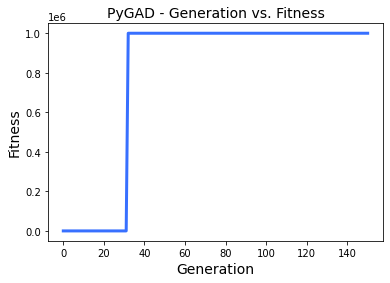

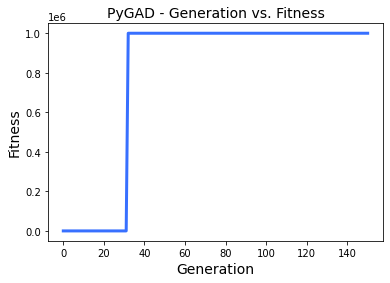

In [2290]:
# We can plot how the GA fitness evolved through generations
ga_instance.plot_fitness()

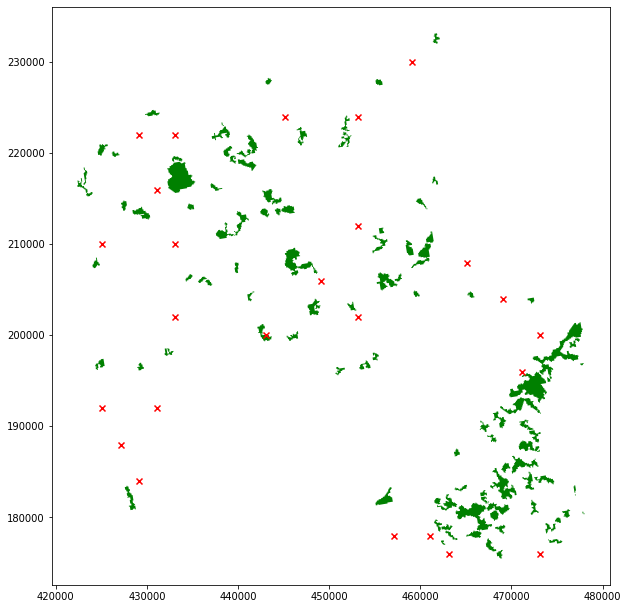

In [2299]:
# We can plot the best solution together with the original woodland
new_xy = [(solution[i],solution[i+1]) for i in range(0,len(solution),2)]

ax = oxonBroadleaf_df.plot(figsize=(10,25),color='g')
ax.scatter(*zip(*new_xy), c="red", marker="x")
plt.show()

Having optimised to create a fully connected graph at 5km, we can plot the overall graph with the addtional nodes that enable this connectivity. in the plot below, we can see how the isolated component in the south west has been joined to the rest of the graph in order to create one component overall.

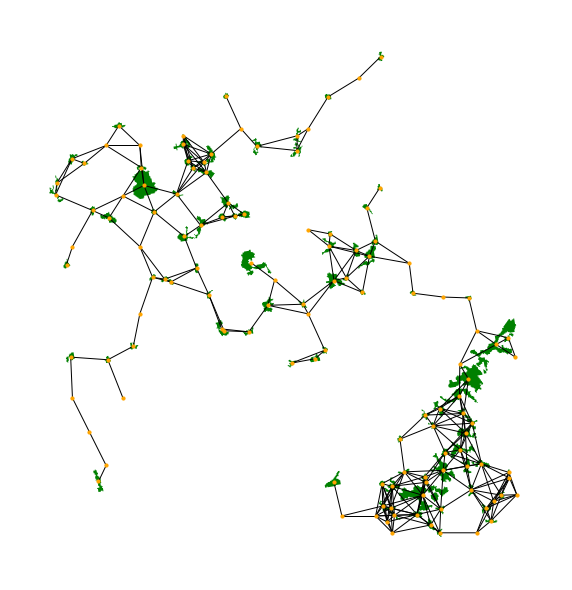

In [2305]:
# Create one set for all woodland coordinates
all_pts = np.append(centroids, new_xy,axis=0)

# Create  graph comprising original and addiotnal woodland nodes
w = weights.DistanceBand.from_array(all_pts, threshold=max_dist_between_nodes)
G = w.to_networkx()

# Integrate geopspatial position with graph nodes
positions = dict(zip(G.nodes, all_pts))

# Render graph and original woodland
ax = oxonBroadleaf_df.plot(figsize=(10,25),color='g')
ax = nx.draw(G, positions, node_size=10, node_color="orange")
plt.show()

We can go further and create the minimum spanning tree, in order to see which edges are essentially to allow a complete traverse of the graph, G.

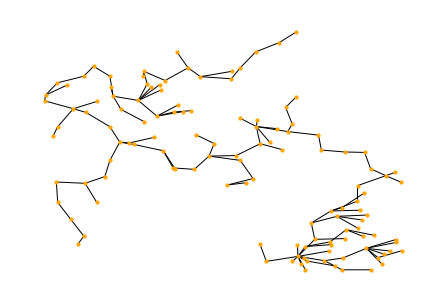

In [2316]:
T = nx.minimum_spanning_tree(G)
ax = nx.draw(T, positions, node_size=10, node_color="orange")
plt.show()

In [2311]:
#What is ther average number of hops to get between nodes of the Graph, G
nx.average_shortest_path_length(G)

12.560129032258065

In [2317]:
nx.number_connected_components(G)

1